### Load Option Data

We begin by importing end-of-day option chain data and computing forward price and the mid prices from bid-ask quotes.


In [12]:
import polars as pl
import numpy as np
from gvv.black_scholes_functions import find_implied_volatilities, calculate_greeks


df = pl.read_csv('spx_eod_201808_cleaned.csv').with_columns([
    ((pl.col(' [C_BID]') + pl.col(' [C_ASK]')) / 2).alias(' [C_MID]'),
    ((pl.col(' [P_BID]') + pl.col(' [P_ASK]')) / 2).alias(' [P_MID]')
])

puts_df = df.filter(pl.col(' [P_IV]') > 0.0).select(pl.col([' [STRIKE]', ' [P_MID]', ' [P_IV]']))
calls_df = df.filter(pl.col(' [C_IV]') > 0.0).select(pl.col([' [STRIKE]', ' [C_MID]', ' [C_IV]']))

S = 2901.2
T = 50/365
r = 0.02
q=0.0177
# F = K + exp(-r * T) * (C_MID - P_MID)
F = 2905 + np.exp(-r * T) * (41.595 - 42.94)

### Visualize Market Implied Volatility

Plot the raw implied volatilities for both call and put options.


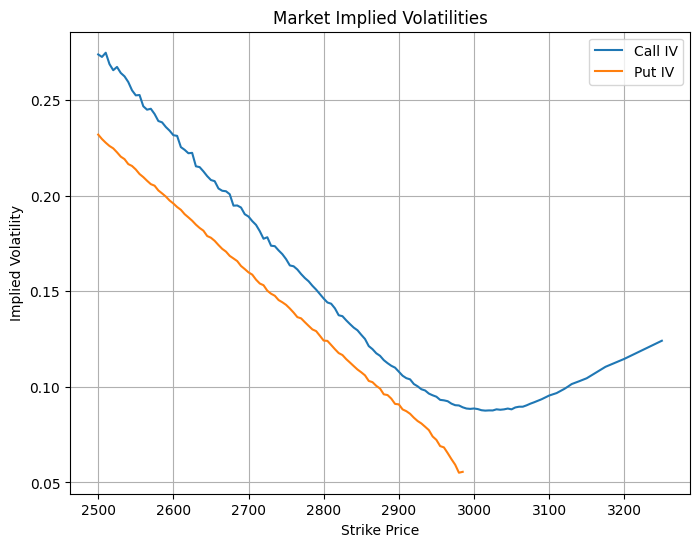

In [13]:
import matplotlib.pyplot as plt

# market implied vols
plt.figure(figsize=(8, 6))
plt.plot(calls_df[' [STRIKE]'], calls_df[' [C_IV]'], label='Call IV')
plt.plot(puts_df[' [STRIKE]'][:-8], puts_df[' [P_IV]'][:-8], label='Put IV')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Market Implied Volatilities')
plt.grid()
plt.legend()
plt.show()


## Back Out Implied Volatilities Using Forward Prices

Use forward pricing rather than spot to compute implied volatilities.


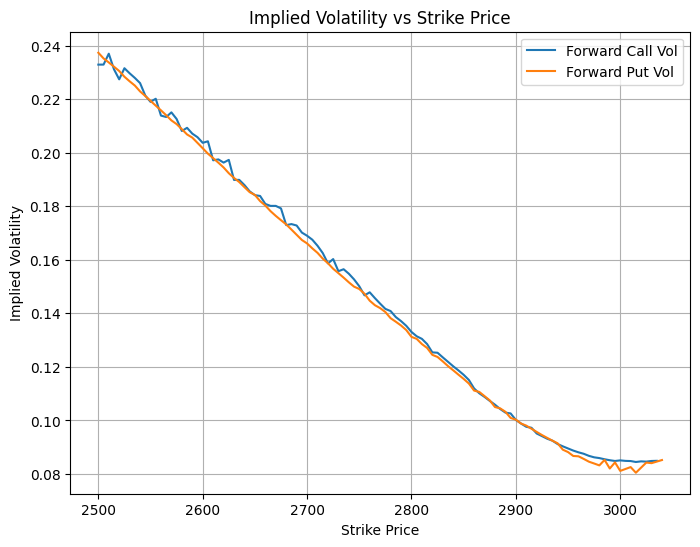

In [14]:
# back out the implied vols using the forward price

call_vols = find_implied_volatilities(calls_df[' [STRIKE]', ' [C_MID]'].iter_rows(), F, T, r, q=q, option_type='call', forward_price=True)
put_vols = find_implied_volatilities(puts_df[' [STRIKE]', ' [P_MID]'].iter_rows(), F, T, r, q=q, option_type='put', forward_price=True)

plt.figure(figsize=(8, 6))
plt.plot(call_vols['STRIKE'][:-20], call_vols['IMPLIED_VOL'][:-20], label='Forward Call Vol')
plt.plot(put_vols['STRIKE'], put_vols['IMPLIED_VOL'], label='Forward Put Vol')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.grid()
plt.title('Implied Volatility vs Strike Price')
plt.legend()
plt.show()


### Compute Option Greeks

Using the implied volatilities, compute gamma, vanna, volga, and theta for each strike.

In [15]:
# calculate the greeks using the implied vols from the forward prices
call_greeks = calculate_greeks(call_vols['STRIKE', 'IMPLIED_VOL'].iter_rows(), S, T, r, q=q, option_type='call', forward_price=False)
put_greeks = calculate_greeks(put_vols['STRIKE', 'IMPLIED_VOL'].iter_rows(), S, T, r, q=q, option_type='put', forward_price=False)


### Calibrate GVV Parameters and Generate Volatility Smile

Calibrate the GVV model parameters (σ, η, ρ) using two options in the wings and one atm, and reconstruct the implied volatility curve across the strikes.


In [16]:
from gvv.gvv_functions import gvv_implied_vol, solve_gvv_linear
from gvv.black_scholes_functions import find_implied_volatilities

# test using SPX options data from 2018-08-30. maturity Oct 18
# using 10 delta wings
greeks = {
    'put_wing': {
        'gamma': 0.0009503138644888251,
        'volga': 1689.3859860143502,
        'vanna': -1.2347780999444595,
        'vol': 0.1731965047180588
    },
    'call_atm': {
        'gamma': 0.0037493217207491044,
        'volga': 1.74371408196338,
        'vanna': 0.1830143636722445,
        'vol': 0.09884871034844739
    },
    'call_wing': {
        'gamma': 0.0019926654664600154,
        'volga': 3703.296373461481,
        'vanna': 2.75026843095933,
        'vol': 0.08473045108357832
    }
}

x = [0.09703471, 0.20334354, -0.05]  # Initial guess for sigma, eta, rho
S = 2901.2 # Current underlying price
T = 50/365
r = 0.02
q=0.0177

# use linear solver to find the three params
sigma, eta, rho = solve_gvv_linear(greeks, S)
print(f'Sigma: {sigma}, Eta: {eta}, Rho: {rho}')

Sigma: 0.09993936472558623, Eta: 1.2473906767980154, Rho: -0.5248825057083945


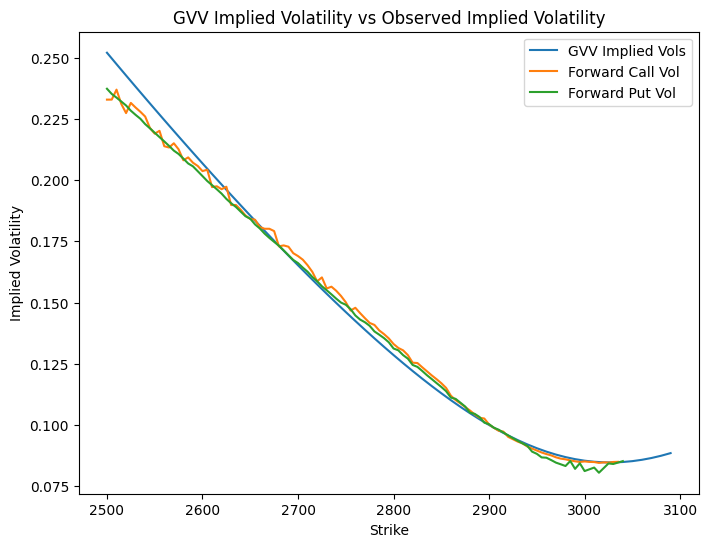

In [17]:
# find the implied vols from 2500 to 3100 with a step of 10
strikes = np.arange(2500, 3100, 10)

# calculate the implied vols using the GVV equation
implied_vols = gvv_implied_vol(S, strikes, T, r, q, sigma, eta, rho)

plt.figure(figsize=(8, 6))
plt.plot(strikes, implied_vols, label='GVV Implied Vols')
plt.plot(call_vols['STRIKE'][:-20], call_vols['IMPLIED_VOL'][:-20], label='Forward Call Vol')
plt.plot(put_vols['STRIKE'], put_vols['IMPLIED_VOL'], label='Forward Put Vol')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.legend()
plt.title('GVV Implied Volatility vs Observed Implied Volatility')
plt.show()

### Compute Greeks from Fitted Surface

Using the implied vols generated by the GVV model, recompute Greeks.


In [18]:
vol_n_strike = list(zip(strikes, implied_vols))

call_greeks = calculate_greeks(vol_n_strike, S, T, r, q=q, option_type='call', forward_price=False)
put_greeks = calculate_greeks(vol_n_strike, S, T, r, q=q, option_type='put', forward_price=False)


# Rename columns and add option type as a new column
call_mapping = {col: col.replace('C_', '') for col in call_greeks.columns if col.startswith('C_')}
put_mapping = {col: col.replace('P_', '') for col in put_greeks.columns if col.startswith('P_')}

call_greeks = (call_greeks
               .rename(call_mapping)
               .with_columns(pl.lit('call').alias('option_type')))
put_greeks = (put_greeks
              .rename(put_mapping)
              .with_columns(pl.lit('put').alias('option_type')))

combined_greeks = call_greeks.vstack(put_greeks).sort('STRIKE')
combined_greeks.head()

STRIKE,PRICE,IMPLIED_VOL,DELTA,VEGA,GAMMA,VANNA,VOLGA,THETA,option_type
i64,f64,f64,f64,f64,f64,f64,f64,f64,str
2500,406.848277,0.252034,0.94777,110.351753,0.00038,-0.632949,1118.392273,-99.702534,"""call"""
2500,5.834231,0.252034,-0.049808,110.351753,0.00038,-0.632949,1118.392273,-101.066215,"""put"""
2510,396.964146,0.247373,0.946279,112.975125,0.000396,-0.654839,1146.987327,-100.381738,"""call"""
2510,5.922741,0.247373,-0.051299,112.975125,0.000396,-0.654839,1146.987327,-101.545966,"""put"""
2520,387.086571,0.242743,0.944696,115.736096,0.000414,-0.677798,1176.379136,-101.105504,"""call"""


### Decompose Theta Using the GVV Framework

The GVV equation implies that theta can be attributed to the cost of holding gamma, vanna, and volga. Decompose theta into these components and visualize their contribution to P&L. Example using 2500P, 2600P, 2700P, 2800C, 2920C, 3000C.

In [19]:
# the gvv model allows us to attribute the an options theta
# to the greeks and how much the market is charging for them
dt = 1/365

dS2 = 0.5 * (S * sigma)**2 * dt
dSig2 = 0.5 * eta**2 * dt
dSig = S * rho * sigma * eta * dt


pnl_df = (put_greeks.filter(pl.col('STRIKE').is_in([2500, 2600, 2700]))
          .vstack(call_greeks.filter(pl.col('STRIKE').is_in([2800, 2920, 3000])))
          .select(pl.col(['STRIKE', 'IMPLIED_VOL', 'GAMMA', 'VANNA', 'VOLGA']))
          .with_columns(
            pl.col('GAMMA') * dS2, # dollar gamma
            pl.col('VANNA') * pl.col('IMPLIED_VOL') * dSig, # dollar vanna
            pl.col('VOLGA') * pl.col('IMPLIED_VOL')**2 * dSig2 # dollar volga
            )
        ).to_pandas()   

pnl_df

,STRIKE,IMPLIED_VOL,GAMMA,VANNA,VOLGA
0,2500,0.252034,0.043731,0.082969,0.151424
1,2600,0.206833,0.069609,0.097589,0.130951
2,2700,0.165206,0.124075,0.114317,0.100659
3,2800,0.128538,0.245591,0.111623,0.049041
4,2920,0.095707,0.440591,-0.039091,0.002564
5,3000,0.085400,0.292926,-0.129237,0.050206


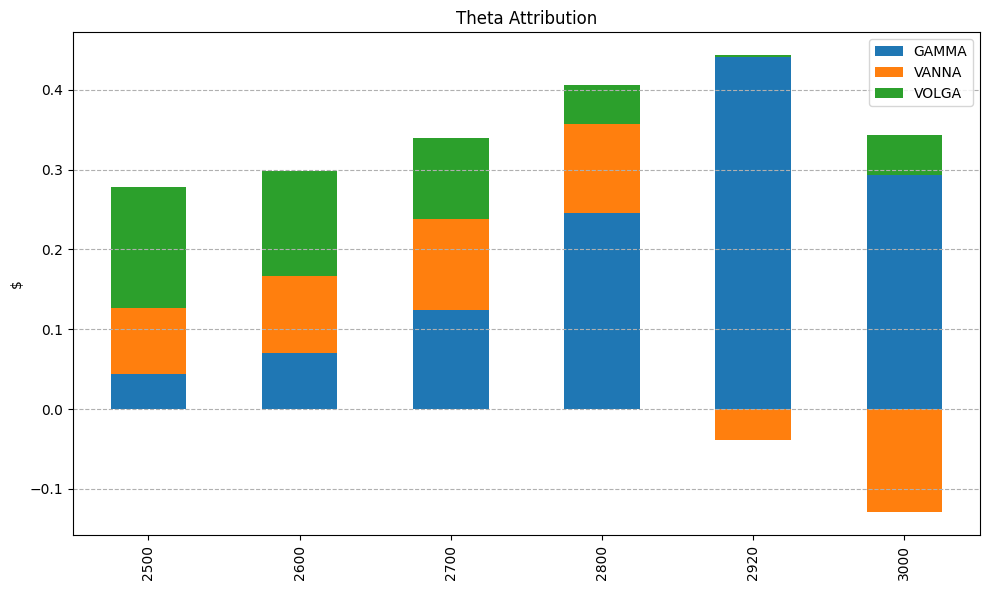

In [20]:
fig, ax = plt.subplots(figsize=(10,6))

pnl_df = pnl_df.set_index('STRIKE')

pnl_df[["GAMMA","VANNA","VOLGA"]].plot(
        kind="bar", stacked=True, ax=ax)


ax.set_ylabel("$")
ax.set_xlabel("")                    
ax.set_title("Theta Attribution")
ax.legend(title="")                  
ax.grid(axis="y", linestyle="--")    

plt.tight_layout()
plt.show()